In [3]:
import pandas as pd
import pystan
import numpy as np
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
import scipy.stats as stats
import os
home = os.getcwd()
os.chdir("/Users/mqwilber/Dropbox/Documents/Stats/Stan/PSIS/py/")
import psis
os.chdir(home)
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = "white"

In [2]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# Fitting the laboratory data to the neutral models

Notes

1. There are many frogs with no Bd. These frogs have a ton of variance in Bd loads that is potentially driving some of the patterns we are seeing with. Variance is so huge at no Bd probably because of the lack of a strong metacommunity. Drift is an important driving force.

In [4]:
labdata = pd.read_csv("../data/jani_2011_timeseries/data/Absolute_Abund.csv")
bddata = pd.read_csv("../data/archival/Bd_Load.csv")
weightdata = pd.read_excel("../data/archival/ExperimentalWeightDataStacked_WithFactors.xlsx")
frog_ids = [i[0] for i in bddata.Group.str.split("_")]
bddata = bddata.assign(frog_ID = frog_ids)

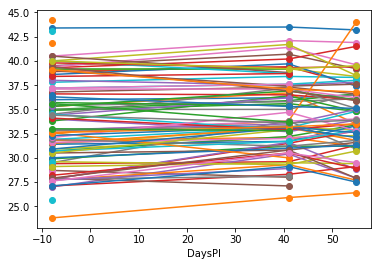

In [5]:
_ = weightdata.set_index("DaysPI").groupby("TankNum")["SVL (mm)"].plot(marker='o')

SVL variance is much higher across frogs than across time. So let's just use mean body size.

In [5]:
svl = (weightdata.groupby("TankNum")
                .agg({'SVL (mm)': np.mean})
                .reset_index()
                .rename(columns={"TankNum": "frog_ID", "SVL (mm)": "svl"}))
svl.frog_ID = svl.frog_ID.astype(np.str)

In [6]:
alldata = labdata.set_index("Group").join(bddata.set_index("Group"))
alldata = alldata[alldata.columns[list(range(-5, 0)) + 
                                  list(range(len(alldata.columns) - 5))]]

# Drop AJ samples
alldata = alldata[~(alldata.frog_ID.str.contains("AJ") | 
          alldata.frog_ID.str.contains("DN") | 
          alldata.frog_ID.str.contains("NTC"))].reset_index(drop=True)

# Drop all frogs not part of main experiment
main_or_side = pd.read_excel("../data/archival/Main or Side Expt.xlsx")
treatment = pd.Series(["-".join(s[:2]) for s in main_or_side.tankID.str.split("-")])
main_or_side = main_or_side.assign(treatment=treatment)
ids = main_or_side[main_or_side.experiment == "main"]
keepids = ids.TankNum.astype(np.str)
alldata = alldata[alldata.frog_ID.isin(keepids)]

# Join the treatment data to alldata
main_or_side = main_or_side.rename(columns={"TankNum": "frog_ID"})
main_or_side.frog_ID = main_or_side.frog_ID.astype(np.str)
alldata = (alldata.set_index("frog_ID")
                  .join(main_or_side.set_index("frog_ID")[["treatment"]])
                  .reset_index())
alldata = alldata[[alldata.columns[-1]] + list(alldata.columns[:-1])]

# Join the svl data
alldata = alldata.set_index("frog_ID").join(svl.set_index("frog_ID"))
alldata = alldata[[alldata.columns[-1]] + list(alldata.columns[:-1])].reset_index()

alldata.to_csv("../results/formatted_lab_data.csv", index=False)

# Drop all frogs with 0 Bd load
#alldata = alldata[alldata.ZE != 0]

In [8]:
alldata.treatment.unique()

array(['Mar-Ebb', 'Mar-Mar', 'Mar-Mono', 'Mar-Uni', 'Mar-Arr', 'Dus-Arr',
       'Dus-Bar', 'Dus-Dus', 'Dus-Ebb', 'Dus-Mar', 'Dus-Mono', 'Mar-Bar',
       'Dus-Uni', 'Mar-Dus'], dtype=object)

In [6]:
alldata

,frog_ID,svl,treatment,day,day.PI,ZE,log.ZE.1.,label,numOtus,Otu00001,...,Otu01877,Otu01878,Otu01879,Otu01880,Otu01881,Otu01882,Otu01883,Otu01884,Otu01885,Otu01886
0,10,38.166667,Mar-Ebb,0.0,-22.0,0.00,0.00,0.04,1886,15,...,0,0,0,0,0,0,0,0,0,0
1,10,38.166667,Mar-Ebb,22.0,0.0,0.00,0.00,0.04,1886,7,...,0,0,0,0,0,0,0,0,0,0
2,10,38.166667,Mar-Ebb,43.0,21.0,0.00,0.00,0.04,1886,1006,...,0,0,0,0,0,0,0,0,0,0
3,11,38.566667,Mar-Ebb,0.0,-22.0,0.00,0.00,0.04,1886,593,...,0,0,0,0,1,0,0,0,0,0
4,11,38.566667,Mar-Ebb,22.0,0.0,0.00,0.00,0.04,1886,10,...,0,0,0,0,0,0,0,0,0,0
5,11,38.566667,Mar-Ebb,43.0,21.0,0.00,0.00,0.04,1886,12,...,0,0,0,0,0,0,0,0,0,0
6,12,31.700000,Mar-Ebb,0.0,-22.0,0.00,0.00,0.04,1886,278,...,0,0,0,0,0,0,0,0,0,0
7,12,31.700000,Mar-Ebb,22.0,0.0,0.00,0.00,0.04,1886,181,...,0,0,0,0,0,0,0,0,0,0
8,12,31.700000,Mar-Ebb,43.0,21.0,0.00,0.00,0.04,1886,193,...,0,0,0,0,0,0,0,0,0,0
9,13,35.100000,Mar-Mar,0.0,-22.0,0.00,0.00,0.04,1886,0,...,0,0,0,0,0,0,0,0,0,0


## Fitting the laboratory data to understand community assembly 

In [7]:
#betabinom = pystan.StanModel("stan_code/neutral_beta_binomial.stan")
betabinom = pd.read_pickle("stan_code/neutral_beta_binomial.pkl")

In [8]:
#betabinom_mean = pystan.StanModel("stan_code/neutral_beta_binomial_meaneffects.stan")
betabinom_mean = pd.read_pickle("stan_code/neutral_beta_binomial_meaneffects.pkl")

In [9]:
#betabinom_meanrand = pystan.StanModel("stan_code/neutral_beta_binomial_meanrandomeffects.stan")
betabinom_meanrand = pd.read_pickle("stan_code/neutral_beta_binomial_meanrandomeffects.pkl")

In [10]:
betabinom_meanrandfrog = pystan.StanModel("stan_code/neutral_beta_binomial_meanrandomfrogeffects.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_174175d6270a5b68a6bc7ccc2670b092 NOW.


In [11]:
dirichlet_mean = pd.read_pickle("stan_code/neutral_dirichlet_multinomial_meaneffects.pkl")

In [22]:
otu_data = alldata.iloc[:, 9:]

metacomm_p = (otu_data.T / otu_data.sum(axis=1)).T.mean(axis=0).sort_values(ascending=False)
sorted_otus = otu_data[metacomm_p.index.values]

# Group on the most abundant OTUs in the metacommunity and other OTUs
num_otus = 19
samp_size = sorted_otus.shape[0]
Nts = sorted_otus.sum(axis=1).values
abund_otus = sorted_otus.iloc[:, :num_otus]
other_otus = sorted_otus.iloc[:, num_otus:].sum(axis=1)
abund_otus = abund_otus.assign(Other=other_otus)
abund = abund_otus.values

relative_otus = (abund_otus.values.T / abund_otus.sum(axis=1).values).T

meta_p_otus = np.append(metacomm_p.values[:num_otus], metacomm_p.values[num_otus:].sum())
alldata.loc[:, "logZE_z"] = StandardScaler().fit_transform(np.log10(alldata.ZE + 1)[:, np.newaxis])
alldata.loc[:, "day_z"] = StandardScaler().fit_transform(alldata.day[:, np.newaxis])

Xmat = dmatrix("scale(svl) + logZE_z", data=alldata, return_type="dataframe").values
Xday = dmatrix("scale(svl) + day_z", data=alldata, return_type="dataframe").values
XBdday = dmatrix("logZE_z + day_z", data=alldata, return_type="dataframe").values
Xonlyday = dmatrix("day_z", data=alldata, return_type="dataframe").values
Xmatday = dmatrix("scale(svl) + logZE_z + day_z", data=alldata, return_type="dataframe").values
Xmattreatment = dmatrix("scale(svl) + logZE_z + C(treatment)", data=alldata, return_type="dataframe").values
XmatBd = dmatrix("logZE_z", data=alldata, return_type="dataframe").values
Xmat2 = dmatrix("scale(svl) + logZE_z + np.power(logZE_z, 2)", data=alldata, return_type="dataframe").values
Xones = np.repeat(1, samp_size)[:, np.newaxis]
Xsvl = dmatrix("scale(svl)", data=alldata, return_type="dataframe").values
Xtreatment = dmatrix("C(treatment)", data=alldata, return_type="dataframe").values
XtreatmentBd = dmatrix("C(treatment) + logZE_z", data=alldata, return_type="dataframe").values
XtreatmentBd2 = dmatrix("C(treatment) + logZE_z + np.power(logZE_z, 2)", data=alldata, return_type="dataframe").values
Xtreatmentday2 = dmatrix("C(treatment) + day_z + np.power(day_z, 2)", data=alldata, return_type="dataframe").values
XBd2 = dmatrix("logZE_z + np.power(logZE_z, 2)", data=alldata, return_type="dataframe").values
U = pd.get_dummies(alldata.frog_ID).values # Individual random effects of frogs

# (model, Dispersal fixed effects, dispersal random effects, mean fixed effects, community-level random effects)
model_Xs = {'base':   (betabinom_mean, Xones, Xones, Xones, None),
            'mean-treatment': (betabinom_mean, Xones, Xones, Xtreatment, None),
            'mean-treatment_I-svl': (betabinom_mean, Xsvl, Xones, Xtreatment, None),
            'mean-treatment_I-svl-Bd': (betabinom_mean, Xmat, Xones, Xtreatment, None),
            'mean-treatment_I-svl-Bd-day': (betabinom_mean, Xmatday, Xones, Xtreatment, None),
            'mean-treatment_I-svl-Bd2': (betabinom_mean, Xmat2, Xones, Xtreatment, None),
            'mean-treatment_I-svl-Bd2_random': (betabinom_meanrand, Xmat2, Xones, Xtreatment, None),
            'mean-treatment_I-svl-Bd_random': (betabinom_meanrand, Xmat, Xones, Xtreatment, None),
            'mean-treatment_I-svl-Bd-day_random': (betabinom_meanrand, Xmatday, Xones, Xtreatment, None),
            'mean-treatment_I-svl-Bd2_random-Bd': (betabinom_meanrand, Xmat2, XmatBd, Xtreatment, None),
            'mean-treatment_I-svl-Bd_random-Bd': (betabinom_meanrand, Xmat, XmatBd, Xtreatment, None),
            'mean-treatment_I-svl-Bd-day_random-Bd-day': (betabinom_meanrand, Xmatday, XBdday, Xtreatment, None),
            'mean-treatment-Bd_I-svl-Bd2_random-Bd': (betabinom_meanrand, Xmat2, XmatBd, XtreatmentBd, None),
            'mean-treatment-Bd2_I-svl-Bd2_random-Bd': (betabinom_meanrand, Xmat2, XmatBd, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl-Bd2_random': (betabinom_meanrand, Xmat2, Xones, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl_random': (betabinom_meanrand, Xsvl, Xones, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl-Bd_random': (betabinom_meanrand, Xmat, Xones, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl_random': (betabinom_meanrand, Xsvl, Xones, XtreatmentBd2, None),
            'mean-treatment_I-svl_random': (betabinom_meanrand, Xsvl, Xones, Xtreatment, None),
            'mean-treatment_I-svl-day_random': (betabinom_meanrand, Xday, Xones, Xtreatment, None),
            'mean-treatment-Bd2_I-svl-Bd_random-Bd': (betabinom_meanrand, Xmat, XmatBd, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl-Bd-day_random-Bd': (betabinom_meanrand, Xmatday, XmatBd, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl-day-random-day': (betabinom_meanrand, Xday, Xonlyday, XtreatmentBd2, None),
            #'mean-treatment-day2_I-svl-day_random-day': (betabinom_meanrand, Xday, Xonlyday, Xtreatmentday2, None),
            'mean-treatment-Bd2_I-svl-Bd-day_random-Bd-day': (betabinom_meanrand, Xmatday, XBdday, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl-Bd-day_random-day': (betabinom_meanrand, Xmatday, Xonlyday, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl-day_random-day': (betabinom_meanrand, Xday, Xonlyday, XtreatmentBd2, None),
            'mean-treatment-Bd_I-svl-Bd_random-Bd': (betabinom_meanrand, Xmat, XmatBd, XtreatmentBd, None),
            'mean-treatment-Bd2_I-svl-Bd_random-Bd-frog': (betabinom_meanrandfrog, Xmat, XmatBd, XtreatmentBd2, U),
            'mean-treatment-Bd2_I-svl-Bd-treatment_random-Bd': (betabinom_meanrand, Xmattreatment, XmatBd, XtreatmentBd2, None),
            'mean-treatment_I-svl-Bd_random-Bd': (betabinom_meanrand, Xmat, XmatBd, Xtreatment, None),
            'mean-Bd2_I-svl-Bd_random-Bd': (betabinom_meanrand, Xmat, XmatBd, XBd2, None),
            'mean-treatment-Bd2_I-svl-Bd': (betabinom_mean, Xmat, Xones, XtreatmentBd2, None),
            'I-svl-Bd_random-Bd': (betabinom_meanrand, Xmat, XmatBd, Xones, None),
            'I-svl-day-Bd_random-Bd-day': (betabinom_meanrand, Xmatday, XBdday, Xones, None),
            'mean-treatment-Bd2': (betabinom_mean, Xones, Xones, XtreatmentBd2, None),
            'mean-treatment-Bd2_I-svl-Bd_random-Bd_dirichlet': (dirichlet_mean, Xmat, XmatBd, XtreatmentBd2, None)}

In [23]:
fits = {}
mnames = ['mean-treatment-Bd2_I-svl-Bd_random-Bd', 
          'mean-treatment-Bd2_I-svl_random',
          'mean-treatment_I-svl_random',
          'mean-treatment_I-svl-Bd-day_random-Bd-day']#list(model_Xs.keys())[-9:]

for model in ['mean-treatment_I-svl-Bd-day', 'mean-treatment_I-svl-Bd-day_random', 
              'mean-treatment_I-svl-day_random', 'mean-treatment_I-svl-Bd-day_random-Bd-day',
             'mean-treatment-Bd2_I-svl-Bd-day_random-day', 'mean-treatment-Bd2_I-svl-day_random-day',
             'I-svl-day-Bd_random-Bd-day']:#list(model_Xs.keys()):

    print("Working on {0}".format(model))
    tmod, X, Z, W, U = model_Xs[model]

    if U is None:
        standata = dict(S = num_otus + 1, N = samp_size, P=X.shape[1], G=Z.shape[1],
                    abund=abund, meta_p=meta_p_otus, X=X, Z=Z, W=W, K=W.shape[1], Nt=Nts)
    else:
        standata = dict(S = num_otus + 1, N = samp_size, P=X.shape[1], G=Z.shape[1],
                    abund=abund, meta_p=meta_p_otus, X=X, Z=Z, W=W, K=W.shape[1], Nt=Nts,
                    F=U.shape[1], U=U)

    fit_field = tmod.sampling(data=standata, iter=4000, warmup=2000, chains=3)

    # Save the model fits for goodness of fit testing
    stanfit = fit_field.extract()
    to_pkl = (stanfit, standata, X, Z, W, alldata.ZE.values)
    pd.to_pickle(to_pkl, "../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))
    fits[model] = fit_field

Working on mean-treatment_I-svl-Bd-day


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Working on mean-treatment_I-svl-Bd-day_random


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Working on mean-treatment_I-svl-day_random


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Working on mean-treatment_I-svl-Bd-day_random-Bd-day


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Working on mean-treatment-Bd2_I-svl-Bd-day_random-day


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Working on mean-treatment-Bd2_I-svl-day_random-day


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Working on I-svl-day-Bd_random-Bd-day


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [24]:
# TODO: CHECK PSIS-LOO DIAGNOSTICS
num_otus = 19
models = list(model_Xs.keys())
noday_models = [m for m in models if m.find("day") != -1]

loos = {}
for model in  noday_models:
    stanfit = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))[0]
    loo_res = psis.psisloo(stanfit['log_lik'])
    print(model, np.sum(loo_res[-1] > 0.7)) # Check PSIS criteria
    loos[model] = [-2*loo_res[0]]

mean-treatment_I-svl-Bd-day 0
mean-treatment_I-svl-Bd-day_random 1
mean-treatment_I-svl-Bd-day_random-Bd-day 3
mean-treatment_I-svl-day_random 1
mean-treatment-Bd2_I-svl-Bd-day_random-Bd 8
mean-treatment-Bd2_I-svl-day-random-day 5
mean-treatment-Bd2_I-svl-Bd-day_random-Bd-day 10
mean-treatment-Bd2_I-svl-Bd-day_random-day 3
mean-treatment-Bd2_I-svl-day_random-day 4
I-svl-day-Bd_random-Bd-day 2


In [18]:
model = "mean-treatment-Bd2_I-svl-Bd_random-Bd"
stanfit = pd.read_pickle("../results/{0}-numOTU{1}_lab.pkl".format(model, num_otus))[0]

In [25]:
model_fits = pd.DataFrame(loos).T.rename(columns={0:"LOO"})
model_fits = model_fits.round(decimals=2)
delta_table = model_fits - model_fits.min(axis=0)
delta_table

,LOO
mean-treatment_I-svl-Bd-day,1822.24
mean-treatment_I-svl-Bd-day_random,976.19
mean-treatment_I-svl-Bd-day_random-Bd-day,345.21
mean-treatment_I-svl-day_random,1028.08
mean-treatment-Bd2_I-svl-Bd-day_random-Bd,479.71
mean-treatment-Bd2_I-svl-day-random-day,143.51
mean-treatment-Bd2_I-svl-Bd-day_random-Bd-day,0.00
mean-treatment-Bd2_I-svl-Bd-day_random-day,144.86
mean-treatment-Bd2_I-svl-day_random-day,143.11
I-svl-day-Bd_random-Bd-day,698.21


In [30]:
nms = dmatrix("scale(svl) + logZE_z + scale(day)", data=alldata, return_type="dataframe").columns
stanfit = pd.read_pickle("../results/model_fits/mean-treatment-Bd2_I-svl-Bd-day_random-Bd-day-numOTU19_lab.pkl")[0]
pd.DataFrame(stats.scoreatpercentile(stanfit['beta'], (2.5, 50, 97.5), axis=0), columns=nms)

,Intercept,scale(svl),logZE_z,scale(day)
0,1.382752,-0.013432,-0.050847,-0.480658
1,2.004716,0.034233,0.221600,-0.129457
2,2.655979,0.082627,0.548535,0.283079


In [34]:
nms = dmatrix("scale(svl) + logZE_z + day_z", data=alldata, return_type="dataframe").columns
stanfit = pd.read_pickle("../results/model_fits/mean-treatment-Bd2_I-svl-Bd_random-Bd-numOTU19_lab.pkl")[0]
pd.DataFrame(stats.scoreatpercentile(stanfit['beta'], (2.5, 50, 97.5), axis=0), columns=nms)

,Intercept,scale(svl),logZE_z
0,1.627585,-0.013406,-0.083439
1,2.169418,0.032611,0.170997
2,2.712902,0.079288,0.421583


In [37]:
stanfit['Beta'].shape

(4000, 3, 19)

## Plot both the lab and the field effects for I

In [8]:
field = pd.read_csv("../data/formatted/OTUdata_formatted.csv")
field.columns = ["_".join(c.split(" ")) for c in field.columns]
field = field.assign(Date_Collected = lambda x: pd.to_datetime(x.Date_Collected))

## DISCARD 11517 AS IT WAS STORED DIFFERENTLY
field = field[field.Lake_ID != 11517]

lake_ids = [72996, 50183, 72425, 72808]
site_dat = (field[(field.Lake_ID.isin(lake_ids)) & (field.sample_type == "swab")]
                 .reset_index(drop=True))
site_dat = site_dat.rename(columns={"SVL":"svl"})

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [96]:
stats.scoreatpercentile(np.array(tpreds), (2.5, 97.5), axis=0)

array([[ 4.75141209,  4.78882837,  4.8265396 ,  4.86454811,  4.90285624,
         4.94146636,  4.98038084,  5.0196021 ,  5.05913256,  5.09897464,
         5.13913081,  5.17960355,  5.22039536,  5.26150875,  5.30294626,
         5.34471044,  5.38680388,  5.42922918,  5.47198895,  5.51508582,
         5.55852247,  5.60230157,  5.64642582,  5.69089794,  5.73572069,
         5.78089683,  5.82642914,  5.87232044,  5.88066568,  5.8738122 ],
       [15.00477182, 15.06323256, 15.11954893, 15.17454078, 15.22973713,
        15.28513875, 15.34074639, 15.39656083, 15.45258284, 15.45870575,
        15.46421156, 15.46972385, 15.47524263, 15.48076793, 15.48629977,
        15.49183816, 15.49738313, 15.50293471, 15.68055257, 15.86858981,
        16.05891006, 16.21873708, 16.28260354, 16.34675001, 16.41117804,
        16.55689666, 16.72865294, 16.89977319, 17.07100593, 17.24399747]])

In [15]:
otu_tax = pd.read_csv("/Users/mqwilber/Repos/amphibian_microbiome/data/jani_2011_timeseries/data/OTU_Taxonomy.csv")
otu_tax = otu_tax.set_index("OTU")

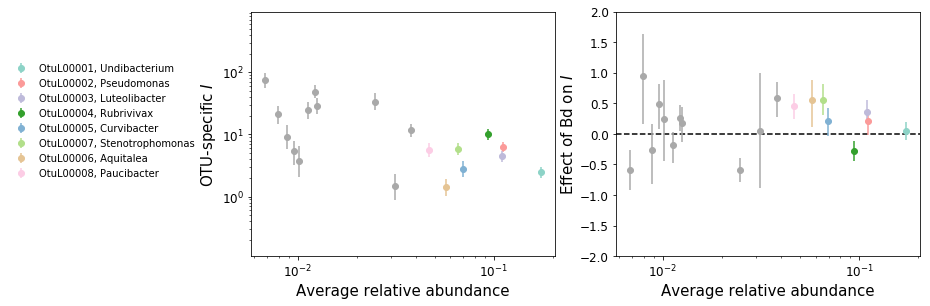

In [31]:
num_otus = 19
colors = ['#8dd3c7','#fb9a99','#bebada','#33a02c','#80b1d3','#b2df8a', '#e5c494','#fccde5']
models = ["mean-treatment-Bd2_I-svl-Bd_random-Bd"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=False, sharey=False)

axes = axes.ravel()
labelsize = 15

for model in  models:
    
    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))

    Ω = stats.scoreatpercentile(stanfit['Omega'], 50, axis=0)
    β = stats.scoreatpercentile(stanfit['Beta'], 50, axis=0)

    logbd = np.log10(bd_load + 1)
    pred_bd = np.linspace(0, np.max(logbd), num=30)
    pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)
    bd_val = (0 - np.mean(logbd)) / np.std(logbd)

#     X = dmatrix("svl + x", data={"x": pred_bd_z, "svl": np.repeat(0, len(pred_bd_z))})
#     Z = dmatrix("x", data={"x": pred_bd_z})

#     Is = np.exp(np.dot(X, β) + np.dot(Z, Ω))
    
#     for col in range(8):
#         axes[0].plot(pred_bd, Is[:, col], lw=3, color=colors[col], label=metacomm_p.index[col] + ", " + otu_tax.loc[metacomm_p.index[col]]['Genus'])
    
#     for col in range(8, 19):
#         axes[0].plot(pred_bd, Is[:, col], color="gray", lw=1, zorder=-1)
    
    
#     axes[0].set_yscale("log")
#     axes[0].set_ylabel("Fundamental recruitment #, I", size=labelsize)
#     axes[0].set_xlabel("log10(Bd load + 1)", size=labelsize)
#     axes[0].legend(loc=(-1.2, 0.3), frameon=False, prop={'size': 10})
    
    tslopes_full = []
    tints_full = []

    # Need to do this via simulation
    rs = np.random.choice(np.arange(stanfit['Beta'].shape[0]), size=500)
    for r in rs:
        
        tΩ = stanfit['Omega'][r, :, :]
        tβ = stanfit['Beta'][r, :, :]
        
        tslopes_full.append((tβ[[0, 2], :] + tΩ[[0, 1], :])[1, :]) # Bd effect 
        tints_full.append(np.exp(np.dot(X, tβ) + np.dot(Z, tΩ))[0, :]) # Take the prediction of I when Bd is absent
        
    tslopes = stats.scoreatpercentile(np.array(tslopes_full), (2.5, 50, 97.5), axis=0)
    tints = stats.scoreatpercentile(np.array(tints_full), (2.5, 50, 97.5), axis=0)
    
    
    num = 19

    # Calculate correlation coefficients
    r1, p1, lo1, hi1 = pearsonr_ci(np.log10(metacomm_p[:num]), tslopes[1, :])
    r2, p2, lo2, hi2 = pearsonr_ci(np.log10(metacomm_p[:num]), tints[1, :])
    
#     axes[0].text(0.5, 0.95, "r = {0:.2f}, [{1:.2f}, {2:.2f}]".format(r1, lo1, hi1), 
#                  ha='center', transform=axes[0].transAxes)
#     axes[1].text(0.5, 0.95, "r = {0:.2f}, [{1:.2f}, {2:.2f}]".format(r2, lo2, hi2), 
#                ha='center', transform=axes[1].transAxes)
    
    for i in range(8):
        
        lab = metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus']
        lab = lab.replace("Otu", "OtuL")
        if lab == "OtuL0007, unclassified":
            lab = "OtuL0007, Comamonadaceae,\nunclassified"
            
        axes[1].errorbar([metacomm_p[i]], 
                         [tslopes[1, i]], yerr=[[tslopes[1, i] - tslopes[0, i]], 
                                                [tslopes[2, i] - tslopes[1, i]]], 
                                         marker="o", linestyle="", color=colors[i], label=lab)
        axes[0].errorbar([metacomm_p[i]], 
                         [tints[1, i]], yerr=[[tints[1, i] - tints[0, i]], 
                                              [tints[2, i] - tints[1, i]]], 
                                         marker="o", linestyle="", color=colors[i])
    for i in range(8, 19):
        axes[1].errorbar([metacomm_p[i]], 
                         [tslopes[1, i]], yerr=[[tslopes[1, i] - tslopes[0, i]], 
                                                [tslopes[2, i] - tslopes[1, i]]], 
                                         marker="o", linestyle="", color="#A9A9A9")
        axes[0].errorbar([metacomm_p[i]], 
                         [tints[1, i]], yerr=[[tints[1, i] - tints[0, i]], 
                                              [tints[2, i] - tints[1, i]]], 
                                         marker="o", linestyle="", color="#A9A9A9")
        
    axes[1].legend(loc=(-2, 0.3), frameon=False, prop={'size': 10})
    axes[1].set_xscale("log")
    axes[1].set_xlabel("Average relative abundance", size=labelsize)
    axes[1].set_ylabel("Effect of Bd on $I$", size=labelsize)
    xlim = axes[1].get_xlim()
    axes[1].hlines(0, *xlim, zorder=-5, linestyle="--")
    axes[1].set_xlim(xlim)
    
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")

    #axes[2].plot(np.log(metacomm_p[:num]), tints[1][:num], 'o')
    axes[0].set_xlabel("Average relative abundance", size=labelsize)
    axes[0].set_ylabel("OTU-specific $I$", size=labelsize)
    
    #axes[0].set_ylim(0.5, 1000)
    axes[1].set_ylim(-2, 2)
    axes[0].set_ylim(0.11, 950)
    
    for ax in axes:
        ax.tick_params(labelsize=12)
#plt.tight_layout()
fig.savefig("../results/dispersal_otu_specific_lab.pdf", bbox_inches="tight")

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono


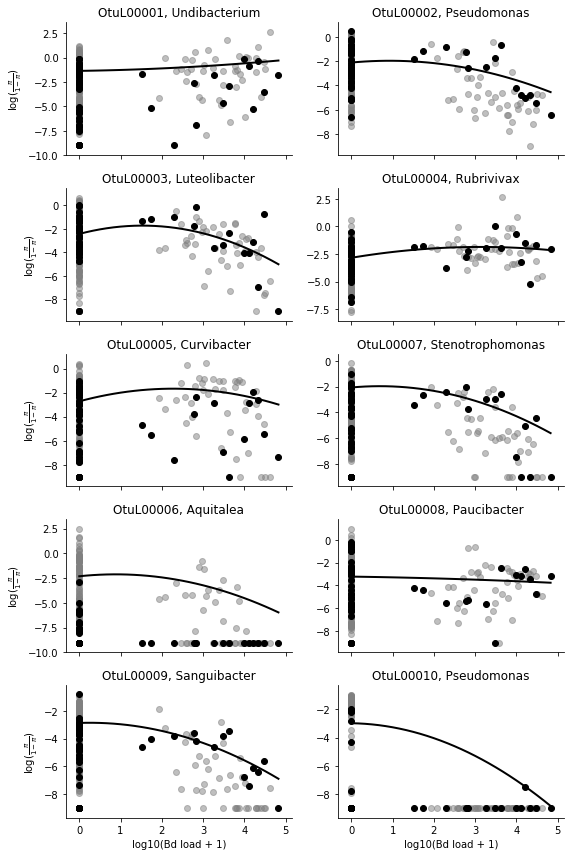

In [22]:
num_otus = 19
colors = sns.color_palette()
models = ["mean-treatment-Bd2_I-svl-Bd_random-Bd"] #
fig, axes = plt.subplots(5, 2, figsize=(8, 12), sharex=True, sharey=False)
axes = axes.ravel()
treatment_ids = alldata.treatment.unique()

for model in  models:

    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))
    
    logbd = np.log10(bd_load + 1)
    pred_bd = np.linspace(0, np.max(logbd), num=30)
    pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)

    for i in range(10):
        ax = axes[i]
#         ax.plot(pred_bd, meta_p_logit[:, i], lw=5, color="gray")#np.exp(meta_p_logit[:, i]) / (1 + np.exp(meta_p_logit[:, i])), lw=5)
#         ax.set_title(metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus'])
        
        count = 0
        for l, treatment in enumerate(treatment_ids):
            
            if l != 0:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, l, 14, 15], :]
                X = dmatrix("ones + x + np.power(x, 2)", data={"x": pred_bd_z, "ones": np.repeat(1, len(pred_bd_z))})
                meta_p_logit = np.dot(X, Beta_meta)
            else:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, 14, 15], :]
                X = dmatrix("x + np.power(x, 2)", data={"x": pred_bd_z})
                meta_p_logit = np.dot(X, Beta_meta)
            
            ind = alldata.treatment == treatment
            logpred = np.log(relative_otus[ind, i]  / (1 - relative_otus[ind, i]))
            
            if l in [2]:
                print(treatment)
                lab = metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus']
                lab = lab.replace("Otu", "OtuL")
                ax.plot(pred_bd, meta_p_logit[:, i], lw=2, color="black")#np.exp(meta_p_logit[:, i]) / (1 + np.exp(meta_p_logit[:, i])), lw=5)
                ax.set_title(lab)
            
                ax.scatter(logbd[ind], logpred, 
                           marker='o', zorder=5, label=treatment, color="black")
                
                zeros = logpred == -np.inf
                ax.scatter(logbd[ind][zeros], np.repeat(-9, np.sum(zeros)), 
                           marker='o', zorder=5, color="black")
                
            else:
                ax.scatter(logbd[ind], logpred, 
                           marker='o', zorder=-1, alpha=0.5, color="gray")
                
                zeros = logpred == -np.inf
                ax.scatter(logbd[ind][zeros], np.repeat(-9, np.sum(zeros)), 
                marker='o', zorder=-1, color="gray", alpha=0.5)
                
        if ax.is_last_row():
            ax.set_xlabel("log10(Bd load + 1)")
        
        if ax.is_first_col():
            ax.set_ylabel(r"$\log(\frac{\pi}{1 - \pi})$")
        
        ax.spines['right'].set_visible(None)
        ax.spines['top'].set_visible(None)
        
#         if i == 0:
#             ax.legend(loc=(-0.55, 0.8), title="Treatment", frameon=False)

plt.tight_layout()
fig.savefig("../results/selection_effects_lab.pdf", bbox_inches="tight")

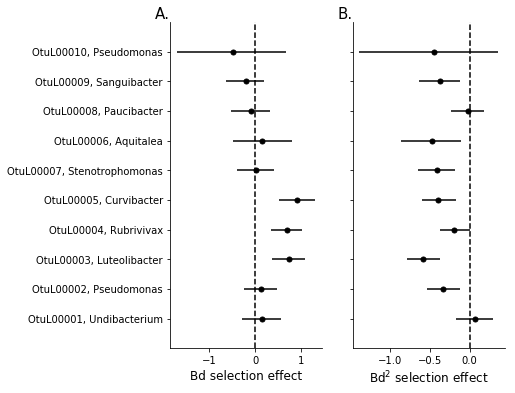

In [27]:
# Plot effect sizes for the top 10 OTUs
fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)
axes = axes.ravel()
model = "mean-treatment-Bd2_I-svl-Bd_random-Bd"
stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))

treatments = alldata.treatment.unique()
num_treatments = len(treatments)
otu_names = []

include_otus = 10
for otu_num in range(include_otus):
    
    otu_names.append(metacomm_p.index[otu_num] + ", " + otu_tax.loc[metacomm_p.index[otu_num]]['Genus'])

    l1, m1, u1 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_treatments], otu_num].sum(axis=1), (2.5, 50, 97.5))
    l2, m2, u2 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_treatments + 1], otu_num].sum(axis=1), (2.5, 50, 97.5))

    axes[0].errorbar([m1], [otu_num], xerr=[[m1 - l1], [u1 - m1]], marker='o', markersize=5, color="black")
    axes[1].errorbar([m2], [otu_num], xerr=[[m2 - l2], [u2 - m2]], marker='o', markersize=5, color="black")

for ax in axes:
    ax.vlines(0, -1, include_otus, zorder=-2, linestyle='--')
    ax.set_yticks(np.arange(include_otus, step=1))
    
    if ax.is_first_col():
        otu_names = [totu.replace("Otu", "OtuL") for totu in otu_names]
        ax.set_yticklabels(otu_names, rotation=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
axes[0].set_ylim(-1, include_otus)
axes[0].set_xlabel("Bd selection effect", size=12)
axes[1].set_xlabel("Bd$^2$ selection effect", size=12)
axes[1].text(-0.05, 1.01, "B.", size=15, ha="center", transform=axes[1].transAxes)
axes[0].text(-0.05, 1.01, "A.", size=15, ha="center", transform=axes[0].transAxes)

#axes[1].legend(loc="lower left", ncol=4, frameon=False)

fig.savefig("../results/selection_effects_lab_cis.pdf", bbox_inches="tight")

In [46]:
dmatrix("C(treatment) + logZE_z + np.power(logZE_z, 2)", data=alldata, return_type="dataframe").columns

Index(['Intercept', 'C(treatment)[T.Dus-Bar]', 'C(treatment)[T.Dus-Dus]',
       'C(treatment)[T.Dus-Ebb]', 'C(treatment)[T.Dus-Mar]',
       'C(treatment)[T.Dus-Mono]', 'C(treatment)[T.Dus-Uni]',
       'C(treatment)[T.Mar-Arr]', 'C(treatment)[T.Mar-Bar]',
       'C(treatment)[T.Mar-Dus]', 'C(treatment)[T.Mar-Ebb]',
       'C(treatment)[T.Mar-Mar]', 'C(treatment)[T.Mar-Mono]',
       'C(treatment)[T.Mar-Uni]', 'logZE_z', 'np.power(logZE_z, 2)'],
      dtype='object')

In [24]:
relative_otus.shape

(290, 20)

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono
Mar-Mono


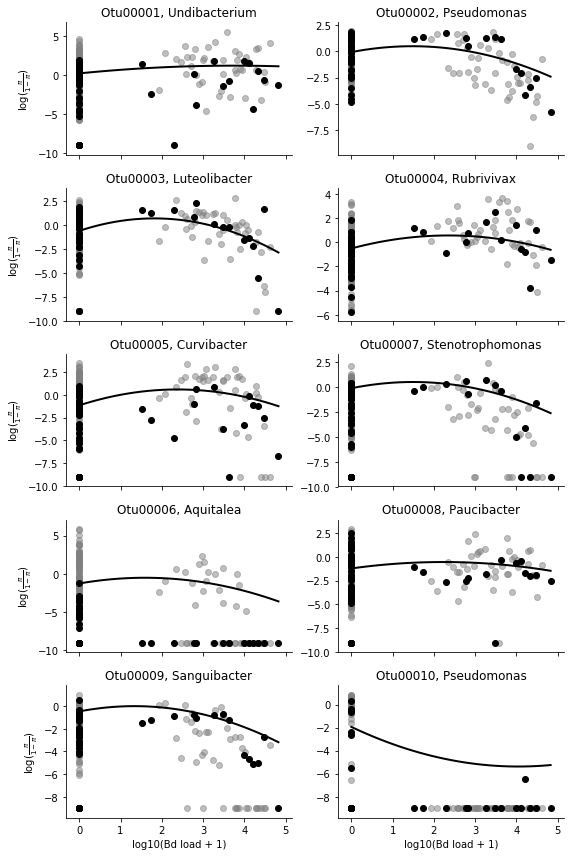

In [44]:
num_otus = 19
colors = sns.color_palette()
models = ["mean-treatment-Bd2_I-svl-Bd_random-Bd_dirichlet"] #
fig, axes = plt.subplots(5, 2, figsize=(8, 12), sharex=True, sharey=False)
axes = axes.ravel()
treatment_ids = alldata.treatment.unique()

for model in  models:

    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))
    
    logbd = np.log10(bd_load + 1)
    pred_bd = np.linspace(0, np.max(logbd), num=30)
    pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)

    for i in range(10):
        ax = axes[i]
#         ax.plot(pred_bd, meta_p_logit[:, i], lw=5, color="gray")#np.exp(meta_p_logit[:, i]) / (1 + np.exp(meta_p_logit[:, i])), lw=5)
#         ax.set_title(metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus'])
        
        count = 0
        for l, treatment in enumerate(treatment_ids):
            
            if l != 0:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, l, 14, 15], :]
                X = dmatrix("ones + x + np.power(x, 2)", data={"x": pred_bd_z, "ones": np.repeat(1, len(pred_bd_z))})
                meta_p_logit = np.dot(X, Beta_meta)
            else:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, 14, 15], :]
                X = dmatrix("x + np.power(x, 2)", data={"x": pred_bd_z})
                meta_p_logit = np.dot(X, Beta_meta)
            
            ind = alldata.treatment == treatment
            logpred = np.log(relative_otus[ind, i]  / (relative_otus[ind, -1]))
            
            if l in [2]:
                print(treatment)
                ax.plot(pred_bd, meta_p_logit[:, i], lw=2, color="black")#np.exp(meta_p_logit[:, i]) / (1 + np.exp(meta_p_logit[:, i])), lw=5)
                ax.set_title(metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus'])
            
                ax.scatter(logbd[ind], logpred, 
                           marker='o', zorder=5, label=treatment, color="black")
                
                zeros = logpred == -np.inf
                ax.scatter(logbd[ind][zeros], np.repeat(-9, np.sum(zeros)), 
                           marker='o', zorder=5, color="black")
                
            else:
                ax.scatter(logbd[ind], logpred, 
                           marker='o', zorder=-1, alpha=0.5, color="gray")
                
                zeros = logpred == -np.inf
                ax.scatter(logbd[ind][zeros], np.repeat(-9, np.sum(zeros)), 
                marker='o', zorder=-1, color="gray", alpha=0.5)
                
        if ax.is_last_row():
            ax.set_xlabel("log10(Bd load + 1)")
        
        if ax.is_first_col():
            ax.set_ylabel(r"$\log(\frac{\pi}{1 - \pi})$")
        
        ax.spines['right'].set_visible(None)
        ax.spines['top'].set_visible(None)
        
#         if i == 0:
#             ax.legend(loc=(-0.55, 0.8), title="Treatment", frameon=False)

plt.tight_layout()
#fig.savefig("../results/selection_effects_lab.pdf", bbox_inches="tight")

Text(-0.05,1.01,'A.')

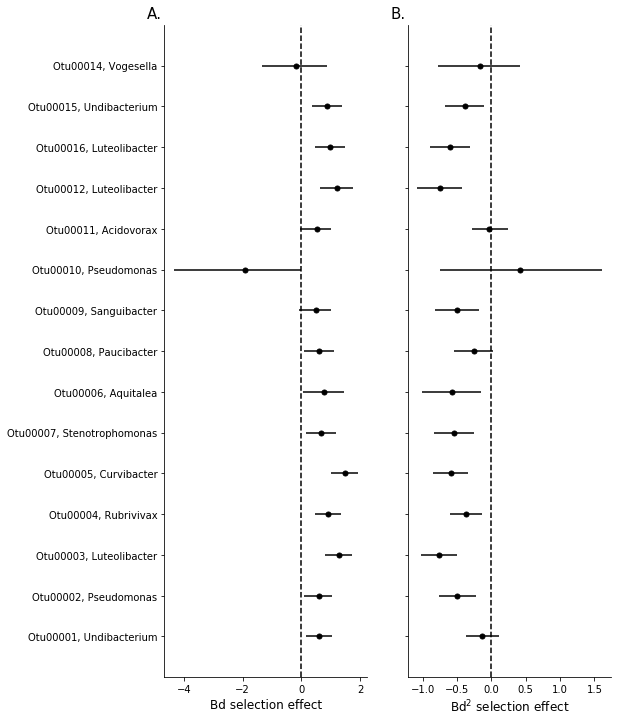

In [38]:
# Plot effect sizes for the top 10 OTUs
fig, axes = plt.subplots(1, 2, figsize=(8, 12), sharey=True)
axes = axes.ravel()
model = "mean-treatment-Bd2_I-svl-Bd_random-Bd_dirichlet"
stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))

treatments = alldata.treatment.unique()
num_treatments = len(treatments)
otu_names = []

include_otus = 15
for otu_num in range(include_otus):
    
    otu_names.append(metacomm_p.index[otu_num] + ", " + otu_tax.loc[metacomm_p.index[otu_num]]['Genus'])

    l1, m1, u1 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_treatments], otu_num].sum(axis=1), (2.5, 50, 97.5))
    l2, m2, u2 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_treatments + 1], otu_num].sum(axis=1), (2.5, 50, 97.5))

    axes[0].errorbar([m1], [otu_num], xerr=[[m1 - l1], [u1 - m1]], marker='o', markersize=5, color="black")
    axes[1].errorbar([m2], [otu_num], xerr=[[m2 - l2], [u2 - m2]], marker='o', markersize=5, color="black")

for ax in axes:
    ax.vlines(0, -1, include_otus, zorder=-2, linestyle='--')
    ax.set_yticks(np.arange(include_otus, step=1))
    
    if ax.is_first_col():
        ax.set_yticklabels(otu_names, rotation=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
axes[0].set_ylim(-1, include_otus)
axes[0].set_xlabel("Bd selection effect", size=12)
axes[1].set_xlabel("Bd$^2$ selection effect", size=12)
axes[1].text(-0.05, 1.01, "B.", size=15, ha="center", transform=axes[1].transAxes)
axes[0].text(-0.05, 1.01, "A.", size=15, ha="center", transform=axes[0].transAxes)

#axes[1].legend(loc="lower left", ncol=4, frameon=False)

#fig.savefig("../results/selection_effects_lab_cis.pdf", bbox_inches="tight")

# Compare independent model and multivariate model

In [40]:
nms = dmatrix("scale(svl) + logZE_z", data=alldata, return_type="dataframe").columns

In [76]:
model = "mean-treatment-Bd2_I-svl-Bd_random-Bd"
stanfit_ind, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))

dt_ind = pd.DataFrame(stats.scoreatpercentile(stanfit_ind['beta'], (2.5, 50, 97.5), axis=0), columns=nms)

In [78]:
model = "mean-treatment-Bd2_I-svl-Bd_random-Bd_dirichlet"
stanfit_mult, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_lab.pkl".format(model, num_otus))
dt_mult = pd.DataFrame(stats.scoreatpercentile(stanfit_mult['beta'], (2.5, 50, 97.5), axis=0), columns=nms)

scale(svl)
logZE_z


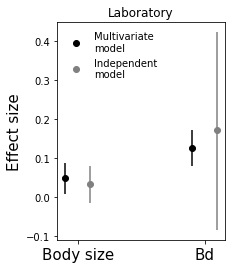

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

columns = dt_mult.columns
for i, col in enumerate(columns[1:]):
    print(col)
    med_mult = dt_mult[col].iloc[1]
    med_ind = dt_ind[col].iloc[1]
    low_mult = med_mult - dt_mult[col].iloc[0]
    high_mult = dt_mult[col].iloc[2] - med_mult
    low_ind = med_ind - dt_ind[col].iloc[0]
    high_ind = dt_ind[col].iloc[2] - med_ind
    
    
    ax.errorbar([i - 0.1], [dt_mult[col].iloc[1]], yerr=[[low_mult], [high_mult]], marker='o', color="black")
    ax.errorbar([i + 0.1], [dt_ind[col].iloc[1]], yerr=[[low_ind], [high_ind]], marker='o', color="gray")

ax.legend([plt.Line2D([0], [0], marker='o', linestyle="", color=c) for c in ["black", "gray"]],
          ("Multivariate\nmodel", "Independent\nmodel"), loc="upper left", frameon=False)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Body size", "Bd"], size=15)
ax.set_ylabel("Effect size", size=15)
ax.set_title("Laboratory")
plt.savefig("../results/multivariate_vs_independent_lab.pdf", bbox_inches="tight")

In [ ]:
up